In [10]:
import torch, matplotlib.pyplot as plt, subprocess, io

In [11]:
from model.speech_to_text import SpeechToText
from model.sign_to_text import SignToText
from model.utils import Logger as LOG
from deep_translator import GoogleTranslator

from media_processing.video import write_video_tensor_to_mp4, write_single_frame_to_png, webm_bytes_to_tensor, tensor_to_webm_bytes, load_mp4video_from_file, VideoPipeline

In [12]:
# video subset from train data
# train = [
#     load_mp4video_from_file(f'./experiment-data/experiment_vids/train{i}.mp4')
#     for i in range(100)
# ]
train = [
    f'./experiment-data/experiment_vids/train{i}.mp4'
    for i in range(100)
]
load_video = lambda video_idx: load_mp4video_from_file(video_idx)

# Downsampling visualizations

In [13]:
def show_frame(video_array,idx=0):
    plt.imshow(video_array[idx].detach().numpy())

In [14]:
def show_seq(video_array, idx_offset):
    w = 35
    h = 35
    fig = plt.figure(figsize=(w, h))
    columns = 10
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        show_frame(video_array, idx=i + idx_offset)
    plt.show()

In [15]:
pipe = VideoPipeline(W_in=260, H_in=210, WH_out=224, k_t=1.)

In [16]:
pipe.k_t = .5
# train_1_2 = [pipe(t, to_file=True) for t in train]

pipe.k_t = .333
# train_1_3 = [pipe(t, to_file=True) for t in train]

# for i, t in enumerate(train):
#     show_seq(t, idx_offset=0)
#     show_seq(train_1_2[i], idx_offset=0)
#     show_seq(train_1_3[i], idx_offset=0)
#     break # only show one vid

# Performance tests

In [17]:
slt_model = SignToText()
google_languages = {
            "US": "en",
            "UK": "en",
            "DE": "de",
            "DK": "da"}

Loading state dicts individually
Training backbone from scratch
Training head network from scratch
Freezing up to block 4 in S3D backbone
Loading model from pretrained checkpoint!


In [18]:
# ! when not performing benchmarks
# del slt_model

In [19]:
LOG.measure_perf = True # ! ENABLE PERFORMANCE MONITORING
from model.utils import monitor_perf

In [20]:
import uuid

red = '\033[91m'
ylw = '\033[93m'
grn = '\033[92m'
blk = '\033[0m'

""" Takes in a list of videos and monitors performance on the full SLT pipeline """
def test_suite_slt(videos, repetitions=1, pipe=None, slt_model=None):
    assert pipe is not None and slt_model is not None, "Missing VideoPipeline and Sign2Text model."
    test_suite_ID = uuid.uuid4()
    for rep in range(repetitions):
        print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}ITER {rep+1}{blk}")
        for video_idx in videos:
            repetition_ID = uuid.uuid4()
            _video = load_video(video_idx)
            # ? get webm bytes, just like we receive via websocket
            data = tensor_to_webm_bytes(_video)

            # video = webm_bytes_to_tensor(data)
            video = monitor_perf(webm_bytes_to_tensor, 
                                 data, width = 224, height = 224, 
                                 test_suite_ID=test_suite_ID, 
                                 repetition_ID=repetition_ID, 
                                 _input=(type(data), len(data)))

            # video, num_frames = pipe(video, to_file=False, output_length=True)
            video, num_frames = monitor_perf(pipe.__call__, 
                                             video, to_file=False, output_length=True, 
                                             variation=f"VideoPipeline, k_t={pipe.k_t}", 
                                             _input=video.shape, 
                                             test_suite_ID=test_suite_ID, 
                                             repetition_ID=repetition_ID)

            # y = slt_model(video, num_frames)[0]
            y = monitor_perf(slt_model.inference, video, num_frames, 
                             variation="Sign2Text", 
                             _input=num_frames, 
                             test_suite_ID=test_suite_ID, 
                             repetition_ID=repetition_ID)[0]

            lang_from, lang_to = "DE", "US"
            # y = GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate(y)
            monitor_perf(GoogleTranslator(source=google_languages[lang_from], target=google_languages[lang_to]).translate, y, 
                         variation="Google Translate", 
                         test_suite_ID=test_suite_ID, 
                         repetition_ID=repetition_ID)
        LOG.perfmon_step()
    print(f"{red}Test Suite [{test_suite_ID}] {ylw}@ {grn}FINISHED{blk}")


In [21]:
LOG.reset_perf_metrics()
# test_suite(train[0:1])
pipe.k_t = 1.
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .5
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)
pipe.k_t = .33333
test_suite_slt(train, repetitions=1, slt_model=slt_model, pipe=pipe)



Test Suite [a5750da8-a544-43ca-820a-83dc88ab30aa] @ ITER 1
[1] Perf @ STARTING :: webm_bytes_to_tensor
[1] Perf @ FINISHED [time: 0.058727026 s] [perf_counter: 0.058727833 s] [process_time: 0.014976000 s] :: webm_bytes_to_tensor
[2] Perf @ STARTING :: __call__
[2] Perf @ FINISHED [time: 0.024096012 s] [perf_counter: 0.024095916 s] [process_time: 0.115164000 s] :: __call__
[3] Perf @ STARTING :: inference


/Users/nielsraunkjaer/Desktop/Bachelor/SltServer/media_processing/video.py:69: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:1468.)
  video_tensor = torch.frombuffer(stdout, dtype=torch.uint8)


[3] Perf @ FINISHED [time: 2.610334158 s] [perf_counter: 2.610339375 s] [process_time: 6.839669000 s] :: inference
[4] Perf @ STARTING :: translate
[4] Perf @ FINISHED [time: 0.156471014 s] [perf_counter: 0.156471292 s] [process_time: 0.020538000 s] :: translate
[5] Perf @ STARTING :: webm_bytes_to_tensor
[5] Perf @ FINISHED [time: 0.069799900 s] [perf_counter: 0.069800708 s] [process_time: 0.020081000 s] :: webm_bytes_to_tensor
[6] Perf @ STARTING :: __call__
[6] Perf @ FINISHED [time: 0.035912037 s] [perf_counter: 0.035912333 s] [process_time: 0.172360000 s] :: __call__
[7] Perf @ STARTING :: inference
[7] Perf @ FINISHED [time: 3.290123224 s] [perf_counter: 3.290130292 s] [process_time: 8.948875000 s] :: inference
[8] Perf @ STARTING :: translate
[8] Perf @ FINISHED [time: 0.154500961 s] [perf_counter: 0.154502000 s] [process_time: 0.011020000 s] :: translate
[9] Perf @ STARTING :: webm_bytes_to_tensor
[9] Perf @ FINISHED [time: 0.061197042 s] [perf_counter: 0.061198416 s] [process_

In [24]:
LOG.perf_metrics#.drop('Unnamed: 0',axis=1)
LOG.save_perf_metrics()

# Visualization

In [25]:
# get the model out of memory :D
del slt_model

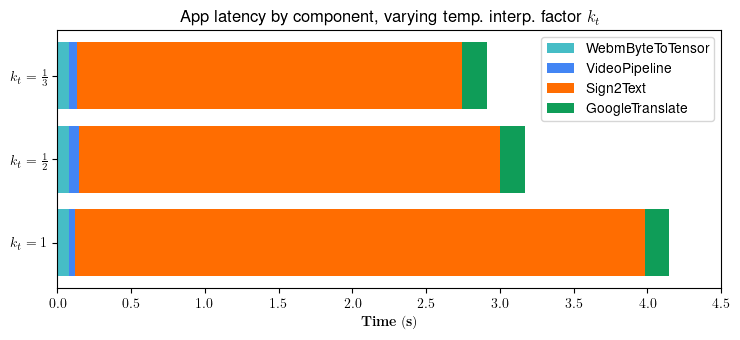

In [121]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

color_map = [
    "#46bdc6",
    "#4285F4",
    "#ff6d01",
    # "#F4B400",
    "#0F9D58",
]

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

kt = ["$k_t = 1$", "$k_t = \\frac{1}{2}$", "$k_t = \\frac{1}{3}$"]

# ! Values computed in spreadsheet found @ [https://tinyurl.com/PerformanceData]
# s2t_pipeline_times =  np.array([[7.67e-02, 7.67e-02, 7.67e-02], # byte_to_tensor
#                                 [4.10e-02, 6.63e-02, 5.35e-02], # video_pipe
#                                 [0.792, 1.03, 1.11],            # s2t_overhead
#                                 [3.075, 1.83, 1.505],           # s2t_variable
#                                 [1.65e-01, 1.65e-01, 1.65e-01], # google_translate
#                                 ]).T
s2t_pipeline_times =  np.array([[7.67e-02, 7.67e-02, 7.67e-02], # byte_to_tensor
                                [4.10e-02, 6.63e-02, 5.35e-02], # video_pipe
                                np.array([0.792, 1.03, 1.11])+            # s2t_overhead
                                np.array([3.075, 1.83, 1.505]),           # s2t_variable
                                [1.65e-01, 1.65e-01, 1.65e-01], # google_translate
                                ]).T

# hacky one-liner because of weird matplotlib hbar syntax
plots = [plt.barh(kt, s2t_pipeline_times[:,0], color=color_map[0])] + \
    [plt.barh(kt, s2t_pipeline_times[:,i], left=np.sum(s2t_pipeline_times[:,:i], axis=1), color=color_map[i]) for i in range(1,len(color_map))]


plt.legend(plots, 
           ["WebmByteToTensor", 
            "VideoPipeline", 
            "Sign2Text", 
            # "Sign2Text [overhead]", 
            # "Sign2Text [variable]", 
            "GoogleTranslate"], 
            loc="upper right")

plt.xticks([x/2 for x in range(9+1)])
plt.xlabel("$\mathbf{Time~(s)}$")
# plt.grid(axis="x")

plt.title("App latency by component, varying temp. interp. factor $k_t$")
# plt.show()
plt.savefig("waterfall_diagram_v3.png")